## Carregamento dos Dados

As imagens foram carregadas a partir de diretórios estruturados por classe e automaticamente organizadas em três subconjuntos: treinamento, validação e teste. Em seguida, foram redimensionadas para 128x128 pixels e agrupadas em lotes (batches) de 32 imagens, facilitando o processamento em paralelo durante o treinamento.

In [1]:
import tensorflow as tf

x_train = tf.keras.utils.image_dataset_from_directory(
    "dataset/train",
    labels="inferred", # Os rótulos são definidos a partir dos nomes das subpastas
    label_mode="categorical", # Formato categórico dos rótulos
    batch_size=32, # Lotes de 32 imagens
    image_size=(128, 128), # Redimensiona as imagens para 128x128
    shuffle=True, # Embaralha as imagens para evitar que a rede aprenda padrões de ordenação
)

x_test = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    labels="inferred", # Os rótulos são definidos a partir dos nomes das subpastas
    label_mode="categorical", # Formato categórico dos rótulos
    batch_size=32, # Lotes de 32 imagens
    image_size=(128, 128), # Redimensiona as imagens para 128x128
    shuffle=False, # Não precisa embaralhar nos dados de teste
)

x_val = tf.keras.utils.image_dataset_from_directory(
    "dataset/validation",
    labels="inferred", # Os rótulos são definidos a partir dos nomes das subpastas
    label_mode="categorical", # Formato categórico dos rótulos
    batch_size=32, # Lotes de 32 imagens
    image_size=(128, 128), # Redimensiona as imagens para 128x128
    shuffle=False, # Não precisa embaralhar nos dados de validação
)

Found 7000 files belonging to 7 classes.
Found 1400 files belonging to 7 classes.
Found 1400 files belonging to 7 classes.


## Normalização

Para garantir maior estabilidade no aprendizado, os valores dos pixels foram normalizados para o intervalo de 0 a 1, por meio da camada "Rescaling(1./255)", o que contribui para uma convergência mais eficiente do modelo.

In [2]:
# Camada que normaliza as imagens do intervalo [0, 255] para [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Aplicação a normalização às imagens de cada dataset
x_train = x_train.map(lambda x, y: (normalization_layer(x), y))
x_val = x_val.map(lambda x, y: (normalization_layer(x), y))
x_test = x_test.map(lambda x, y: (normalization_layer(x), y))

## Criação do Modelo CNN

Para a criação da CNN foi utilizado o modelo **Sequential**, o qual estabelece uma sequência de camadas que são empilhadas e executadas sequencialmente.

### Data Augmentation

Antes de aplicar as camadas da Rede Neural Convolucional, em cada iteração são aplicadas transformações nas imagens, como rotação, zoom e contraste. Isso é feito para que o modelo consiga identificar os diferentes tipos de células mesmo com pequenas mudanças na sua apresentação visual.

### Camada Convolucional

Essa camada detecta os padrões presentes na imagem e retorna as suas características.

Uma camada `Conv2D` usa filtros, uma pequena matriz de números, que desliza sobre a imagem. Em cada posição é realizado uma operação matemática que retorna um número que representa o quão presente é o padrão daquele filtro na imagem; quanto maior o número mais presente será esse padrão. No final dessa operação é retornado um mapa de características. Se tiver 32 filtros, haverá 32 mapas de características diferentes, cada um destacando um tipo específico de padrão.

Em cada mapa é aplicado a função de ativação `ReLU (max(0, z))`, que transforma todas os negativos em 0.

Na primeira camada Convolucional é aplicado **64 filtros** de matriz **3x3** à imagem original de **128x128**, resultando em **32 mapas de características**. Esses filtros aprenderão caracaterísticas de baixo nível, como bordas e cantos.

Os 32 mapas da camada anterior servirão como entrada para a segunda camada, onde **128 novos filtros** percorrerão esses mapas. Os filtros dessa camada irão combinar as características de baixo nível que foram aprendidas na camada anterior para detectar padrões mais complexos. Ao final dessa camada terá **64 novos mapas de características**.

A terceira camada Convolucional executará o mesmo processo anterior com **256 filtros**, resultando em **128 mapas de características** com padrões ainda mais complexos e abstratos.

### Camada de Pooling

Após cada camada Convolucional é executado uma camada de agrupamento, onde o tamanho dos mapas de características é reduzido. Neste caso, o `MaxPooling2D` divide os mapas em regiões **2x2** e seleciona o valor máximo dentro de cada região.

Ao realizar esse processo, o tamanho dos mapas é reduzido pela metade, mantendo apenas as características mais relevantes. Além disso, a diminuição de parâmetros ajuda a prevenir o overfitting.

### Camada de Flatten

Nessa camada a estrutura 3D das informações que foram passadas pelas camadas anteriores são transformadas em um único vetor 1D. Isso é necessário porque as próximas camadas esperam uma entrada em formato de vetor.

### Camada de Dropout

A técnica de `Dropout` atua desativando aleatoriamente uma porcentagem dos neurônios em cada iteração, impedindo que o modelo se torne excessivamente dependente de características específicas. Essa camada evita que o modelo aprenda demais de quaisquer características ajudando a generalizar melhor, evitando o overfitting.

Neste modelo:

- Após cada camada de `Pooling` foi aplicado `Dropout` de 30%, o que significa que 30% dos neurônios foram desativados aleatoriamente a cada passo de treinamento;
- Após a camada `Flatten`, foi aplicado um `Dropout` mais agressivo de 50%, uma vez que é nessa etapa que o modelo está mais propenso a memorizar os dados.

### Camada Densa

As camadas densas são onde as características aprendidas são combinadas para a decisão final, em que os 128 neurônios realizam um cálculo ponderado de todos os valores de entrada do vetor da camada anterior.

$$Output_j = \sum_{i} (Input_i \times Weight_{ij}) + Bias_j$$

O resultado desse cálculo passa pela função de ativação **ReLU**. Se o valor for positivo, ele permanece o mesmo; se for negativo, torna-se zero.

Por fim, é executado a última camada do modelo, em que os 7 neurônios dessa camada, que correspondem às 7 classes das células, recebem a saída dos 256 neurônios da camada anterior e realizam novamente o cálculo ponderado.

As saídas desses 7 neurônios são passados pela função **Softmax**, que converte os valores em probabilidades, onde cada valor está entre **0 e 1**. A soma das probabilidades de todas as 7 saídas sempre será igual a 1. O neurônio com maior probabilidade indica classe que foi prevista pelo modelo.

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), # Vira a imagem aleatoriamente na horizontal e/ou vertical
    tf.keras.layers.RandomRotation(0.1), # Rotaciona em até 10%
    tf.keras.layers.RandomZoom(0.1),     # Zoom em até 10%
    tf.keras.layers.RandomContrast(0.1)  # Ajuste de contraste em até 10%
])

# Modelo sequencial onde as camadas são empilhadas uma acima da outra
model = tf.keras.Sequential([
    # Altera as imagens de treinamento em cada iteração
    data_augmentation,
    # Primeira camada Convolucional 
    tf.keras.layers.Conv2D(64, # Número de filtros
                           (3, 3), # Tamanho do filtro (3 por 3 pixels)
                           activation='relu', # Função de ativação ReLU
                           input_shape=(128, 128, 3)), # Dimenções das imagens

    # Reduz a resolução da imagem pela metade através do agrupamento guloso de um grupo de 2 por 2 pixels
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Evita overfitting desligando 30% dos neurónios de maneira aleatória durante os treinos
    tf.keras.layers.Dropout(0.3),

    # Segunda camada Convolucional 
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    # Terceira camada Convolucional 
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    # Transforma a saída 3D da ultima camada em um vetor de uma dimenção
    tf.keras.layers.Flatten(),
    # Nessa camada 50% dos neurônios são desligados
    tf.keras.layers.Dropout(0.5),

    # Camada com 256 neurônios conectados
    tf.keras.layers.Dense(256, activation='relu'),
    
    # Camada com o numero de tipos de celulas e função de ativação Softmax (transforma valores em probabilidades)
    tf.keras.layers.Dense(7, activation='softmax')
])

## Compilação do Modelo

Aqui o modelo é configurado para treinamento. Durante a compilação são definidos três elementos essenciais:
- <strong>Otimizador</strong>: Algoritmo responsável por realizar ajustes nos pesos da rede neural a cada iteração durante o treinamento com base nos erros. O modelo escolhido foi o <strong>Adam</strong>, que ajusta dinamicamente a taxa de aprendizado e acelera a convergência.
- <strong>Função de perda</strong>: Indica o quão distante está a resposta do valor esperado. A função escolhida foi a categorical crossentropy, adequada para problemas com rótulos armazenados em formato de vetor onde a posição da classe correta fica em 1 enquanto as demais ficam em 0.
- <strong>Métrica de avaliação</strong>: Serve para acompanhar o desempenho do modelo durante o treinamento. Aqui foi usada a acurácia, que mede a proporcão entre a quantidade de acertos e de amostras. 

In [9]:
# Compila o modelo deixado pronto para treino
model.compile(
    # Otimizador 
    optimizer='adam',
    # Função de perda
    loss='categorical_crossentropy',
    # Métrica para acompanhar a acurácia. 
    metrics=['accuracy']
)

## Treinamento

O modelo é treinado usando o _model.fit_, que executa multiplas épocas sobre a base de dados. Cada época passa por um conjunto de validação para acompanhamento do progresso.

O treinamento foi realizado ao longo de 100 épocas, com aplicação de callbacks pra aumentar a eficiência e evitar sobreajuste:

- `EarlyStopping`: interrompe o treinamento caso a perda de validação não apresente melhora após 10 épocas consecutivas;
- `ReduceLROnPlateau`: reduz automaticamente a taxa de aprendizado em 80% sempre que a perda de validação permanecer estagnada por 10 épocas, com taxa mínima limitada a 1e-5.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Monitora a perda de validação
    factor=0.2,         # Reduz a LR para 20% do valor atual
    patience=10,         # Se a val_loss não melhorar em 10 épocas, reduza a LR
    min_lr=0.00001,     # Taxa de aprendizado mínima para evitar que caia demais
    verbose=1           # Para ver quando a LR é ajustada
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True # Garante que o modelo final seja o da melhor época de validação
)

history = model.fit(
    x_train, # Dados de treinamento
    validation_data=x_val, # Validação que acontece a cada época
    epochs=100,  # pode ajustar conforme o desempenho
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
219/219 [==============================] - 149s 646ms/step - loss: 1.8099 - accuracy: 0.2829 - val_loss: 1.5924 - val_accuracy: 0.3821 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 142s 648ms/step - loss: 1.5437 - accuracy: 0.3761 - val_loss: 1.4321 - val_accuracy: 0.4436 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 147s 670ms/step - loss: 1.4642 - accuracy: 0.4174 - val_loss: 1.3759 - val_accuracy: 0.4693 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 137s 626ms/step - loss: 1.4038 - accuracy: 0.4520 - val_loss: 1.2946 - val_accuracy: 0.5071 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 130s 591ms/step - loss: 1.3569 - accuracy: 0.4754 - val_loss: 1.2915 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 127s 582ms/step - loss: 1.3235 - accuracy: 0.4830 - val_loss: 1.2541 - val_accuracy: 0.5171 - lr: 0.0010
Epoch 7/100
219/219 [===================

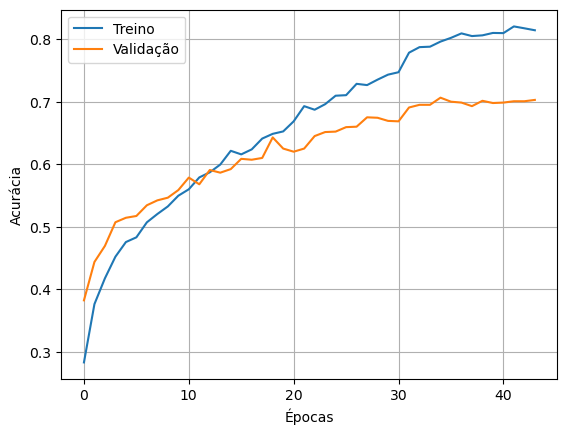

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel("Épocas") # épocas de treinamento
plt.ylabel("Acurácia") # proporção de previsões corretas
plt.legend()
plt.grid()

# Apresenta um gráfico de linha que acompanha a evolução do modelo ao longo do tempo.
plt.show()


## Testes

Essa étapa faz uso do conjunto de dados de teste para julgar o quão bom foi o treinamento do modelo. Ele retorna as métricas definidas na compilação.

In [17]:
test_loss, test_accuracy = model.evaluate(x_test) # Avalia o conjunto de dados
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}") # Imprime a acurácia do treinamento
print(f"Perda no conjunto de teste: {test_loss:.4f}") # Imprime a perda do treinamento

44/44 [==============================] - 6s 135ms/step - loss: 0.8828 - accuracy: 0.7079
Acurácia no conjunto de teste: 0.7079
Perda no conjunto de teste: 0.8828


Após 44 épocas de treinamento e a validação, o modelo de CNN alcançou uma acurácia geral de 70.79% no conjunto de teste, com uma perda de 0.8828. Esse desempenho indica que o modelo tem uma boa capacidade de classificar diferentes imagens de células da medula óssea.

## Avaliação

A avaliação do desempenho é uma etapa crucial para compreender o comportamento modelo.

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# O predict() retorna as probabilidades para cada classe
predictions = model.predict(x_test)

# Obtém a classe prevista
predicted_classes = np.argmax(predictions, axis=1)

true_labels = []
for images, labels in x_test.unbatch(): # Itera sobre dataset sem lotes o
    # Obtém os índices de cada classe
    true_labels.append(np.argmax(labels.numpy()))

true_labels = np.array(true_labels)

44/44 [==============================] - 8s 191ms/step


Para realizar uma análise mais detalhada do desempenho em cada classe, é apresentada uma Matriz de Confusão que ilustra a previsão de cada uma das classes de células de medula óssea, onde a diagonal principal representa o número de previsões corretas e os valores fora da diagonal indicam as confusões da previsão entre as classes.

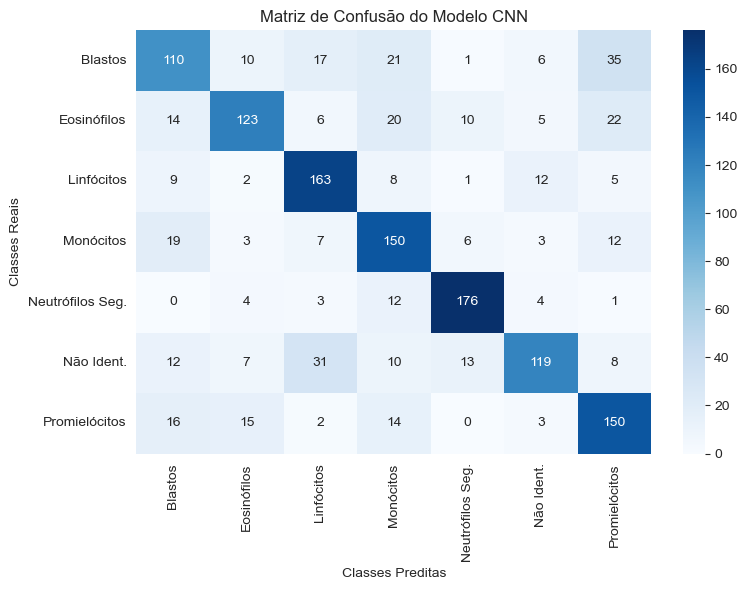

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

matriz_confusao = confusion_matrix(true_labels, predicted_classes)

nomes_classes = ['Blastos', 'Eosinófilos', 'Linfócitos', 'Monócitos', 'Neutrófilos Seg.', 'Não Ident.', 'Promielócitos']

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=nomes_classes, yticklabels=nomes_classes)

plt.xlabel('Classes Preditas')
plt.ylabel('Classes Reais')
plt.title('Matriz de Confusão do Modelo CNN')
plt.tight_layout()
plt.show()

Para agregar mais detalhes à avaliação do modelo, é criado um que relatório exibe as métricas de `precisão`, `recall` e `F1-score` para cada uma das 7 classes, além de suas respectivas médias macro e ponderada.

In [33]:
print(classification_report(true_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58       200
           1       0.75      0.61      0.68       200
           2       0.71      0.81      0.76       200
           3       0.64      0.75      0.69       200
           4       0.85      0.88      0.86       200
           5       0.78      0.59      0.68       200
           6       0.64      0.75      0.69       200

    accuracy                           0.71      1400
   macro avg       0.71      0.71      0.71      1400
weighted avg       0.71      0.71      0.71      1400



O modelo de classificação das imagens de células atingiu uma acurácia geral de aproximadamente 71%. Ao analisar individualmente cada classe, observa-se que a `classe 0 (Blastos)` possui o pior desempenho do modelo, com os menores valores de `precisão` (0.61), `recall` (0.55) e `F1-score` (0.58). Em contrapartida, a `classe 4 (Neutrófilos Seg.)` demonstrou os maiores valores de `precisão` (0.85), `recall` (0.88) e `F1-score` (0.86), indicando um excelente desempenho do modelo na identificação dessa célula. Esses achados corroboram a análise realizada na Matriz de Confusão.

Com relação ao restante das células, o desempenho do modelo foi variável entre as diferentes métricas. Isso indica que, para essas classes, o modelo pode exibir um bom desempenho em uma métrica, mas um resultado consideravelmente mais fraco em outra.

Quanto às médias macro e ponderada, a coincidência de seus valores (71%) com a acurácia geral do modelo indica o balanceamento do conjunto de dados em termos do número de amostras por classe.